In [17]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [80]:
#Генератор батчей
def batch_generator(X, y, batch_size):
    perm = np.random.permutation(len(X))
    num_samples = X.shape[0]
    sample_length = X.shape[1]
    num_batches = num_samples // batch_size
    extra_batch_len = num_samples - (batch_size*num_batches)
    extra_batch_flag = 0
    if (extra_batch_len != 0):
        extra_batch_flag = 1
    for i in range(num_batches + extra_batch_flag):
        if (i == num_batches):
            X_batch = np.zeros((extra_batch_len, sample_length))
            y_batch = np.zeros((extra_batch_len))
            for j in range(extra_batch_len):
                X_batch[j] = X[perm[i*batch_size + j]]
                y_batch[j] = y[perm[i*batch_size + j]]
            yield X_batch, y_batch
        else:
            X_batch = np.zeros((batch_size, sample_length))
            y_batch = np.zeros((batch_size))
            for j in range(batch_size):
                X_batch[j] = X[perm[i*batch_size + j]]
                y_batch[j] = y[perm[i*batch_size + j]]
            yield X_batch, y_batch
            

In [ ]:
#Загружаем данные
data = pd.read_csv('behavior.csv')

In [136]:
#Берем их (имя не влияет на вредоносность, не берем его)
X = data.iloc[:, 1:854]
y = data.iloc[:, -1]

In [137]:
#Нормализуем
X = X - X.mean()
X = np.array(X/X.std())
y = np.array(y)

In [140]:
#Появились NaN -> X.std в колонке = 0 -> убираем колонку (не информативно)
Nans = np.argwhere(np.isnan(X[0]))
X = np.delete(X, Nans, axis = 1)

In [141]:
#Какие признаки важны?
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [142]:
#Отрезаем 30 самых информативных
features_indexes = model.feature_importances_
features_indexes = np.array(features_indexes)
features_indexes = features_indexes.argsort()[-30:]

In [143]:
X = X[:, features_indexes]

In [150]:
#Отрезаем тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

In [194]:
#Модель
model = nn.Sequential(
    nn.Linear(30, 500),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    nn.BatchNorm1d(500),
    nn.Linear(500,500),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    nn.BatchNorm1d(500),
    nn.Linear(500, 2)
)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [195]:
#Функция тренировки + подсчет loss и accuracy (для анализа и улучшения модели)
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 5000):
            model.train(True)
            y_predict = model.forward(torch.FloatTensor(X_batch))
            loss = loss_fn(y_predict, torch.LongTensor(y_batch))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())        
        train_losses.append(np.mean(epoch_train_losses))
        model.train(False)
        with torch.no_grad():
            test_y_predict = model.forward(X_test)
            test_loss = loss_fn(test_y_predict, torch.LongTensor(y_test))
            test_losses.append(test_loss.item())
            train_pred = model.forward(X_train).max(1)[1]
            test_pred = model.forward(X_test).max(1)[1]
            train_accuracy.append(accuracy_score(y_true = y_train, y_pred = train_pred))
            test_accuracy.append(accuracy_score(y_true = y_test, y_pred = test_pred))
            
            
    return train_losses, test_losses, train_accuracy, test_accuracy

In [196]:
#Тренируем модель
train_losses, test_losses, train_accuracy, test_accuracy= train(X_train, y_train, X_test, y_test, 200)

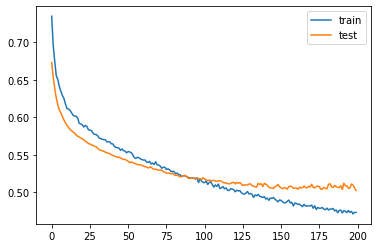

In [197]:
#Смотрим лосс, делаем выводы, правим модель...
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

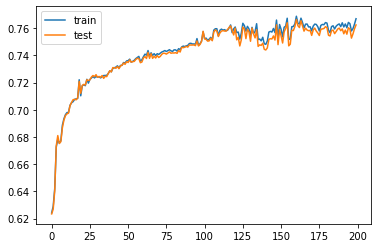

In [198]:
#Смотрим точность, делаем выводы, правим модель...
plt.plot(range(len(train_accuracy)), train_accuracy, label='train')
plt.plot(range(len(test_accuracy)), test_accuracy, label='test')
plt.legend()
plt.show()

In [199]:
#Точность модели (финальная)
model.eval()
train_pred_labels = model.forward(X_train).max(1)[1]
test_pred_labels = model.forward(X_test).max(1)[1]

train_acc = accuracy_score(y_true = y_train, y_pred = train_pred_labels)
test_acc = accuracy_score(y_true = y_test, y_pred = test_pred_labels)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.76696
Test accuracy: 0.7624
